# 期末考核: 使用 Tensorflow 对手写数字进行分类

### 本次考核需要使用 TensorFlow 对来自 [THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/) 的手写数字图像进行分类。 本次编程考核将分为以下几个部分:
>
#### 1. 加载并对数据进行预处理。
#### 2. 根据指示的结构构建 LeNet-5 网络并训练。
#### 3. 分析模型性能。
#### 4. 思考 batch size 对训练的影响。

---
### 1. 加载并可视化数据

#### 1.1 直接从 keras 加载 MNIST 数据并归一化处理。

#### 由于 LeNet-5 的网络输入要求是$32\times32\times1$，而 MNIST 数据集的图片维度大小是 $28\times28\times1$ 的。因此,需要事先扩充数据的维度。(可使用 padding 的方法，具体可见 [Numpy padding 用法][padding])

[padding]: https://numpy.org/doc/stable/reference/generated/numpy.pad.html）

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

gpus = tf.config.experimental.list_physical_devices('GPU')

num_classes = 10

# 加载 MNIST 中的训练集和测试集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant')
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant')

# 使用 Padding 扩充数据维度，将标签数据从离散值转化为 one-hot 向量
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# 使用 train_test_split 函数将训练集的 1% 划分为验证集
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.01, random_state=42)

# 归一化处理数据
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

# 打印数据预处理结果
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')
print(x_test.shape[0], 'test samples')



11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (59400, 32, 32, 1)
x_val shape: (600, 32, 32, 1)
x_test shape: (10000, 32, 32, 1)
y_train shape: (59400, 10)
59400 train samples
600 val samples
10000 test samples


### 1.2 随机选择一张图像并可视化。

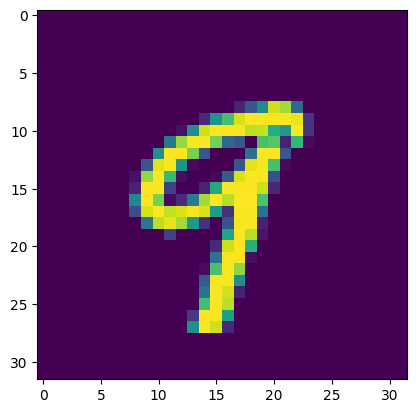

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0])

---
## 2. 构建网络模型

### 2.1 LeNet-5 网络结构
<center><img src="LeNet-5.png" width = "1000"></center>
<center><br>图1：LeNet-5 网络结构</br></center>

1. Convolution #1. Input = 32x32x1. Output = 28x28x6 conv2d

2. SubSampling #1. Input = 28x28x6. Output = 14x14x6. use avg_pool

3. Convolution #2. Input = 14x14x6. Output = 10x10x16 conv2d

4. SubSampling #2. Input = 10x10x16. Output = 5x5x16 avg_pool

5. Fully Connected #1. Input = 5x5x16. Output = 120

6. Fully Connected #2. Input = 120. Output = 84

7. Output 10


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import layers
from time import time

# 创建回调， 保存模型权重
checkpoint_path1 = 'LeNet5_weights.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path1, save_weights_only=True, verbose=1)

# 构建 LeNet-5, 并命名为 LeNet5
# 最后一层的激活函数为‘softmax’， 其余为‘relu’。
LeNet5 = Sequential()
LeNet5.add(Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1)))
LeNet5.add(AveragePooling2D(pool_size=(2, 2)))
LeNet5.add(Conv2D(16, (5, 5), activation='relu'))
LeNet5.add(AveragePooling2D(pool_size=(2, 2)))
LeNet5.add(Flatten())
LeNet5.add(Dense(120, activation='relu'))
LeNet5.add(Dense(84, activation='relu'))
LeNet5.add(Dense(10, activation='softmax'))

# 封装模型
LeNet5.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# 打印模型结构
LeNet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

### 2.2 训练 LeNet-5 网络并绘制训练过程

Epoch 1/20
929/929 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.9227
Epoch 1: saving model to LeNet5_weights.h5
929/929 [==============================] - 15s 8ms/step - loss: 0.2609 - accuracy: 0.9227 - val_loss: 0.1111 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 2/20
927/929 [============================>.] - ETA: 0s - loss: 0.0813 - accuracy: 0.9756
Epoch 2: saving model to LeNet5_weights.h5
929/929 [==============================] - 6s 7ms/step - loss: 0.0813 - accuracy: 0.9756 - val_loss: 0.0568 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 3/20
921/929 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9821
Epoch 3: saving model to LeNet5_weights.h5
929/929 [==============================] - 5s 5ms/step - loss: 0.0579 - accuracy: 0.9821 - val_loss: 0.0489 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 4/20
918/929 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9857
Epoch 4: saving model to LeNet5_weights.h5
929/929 [==

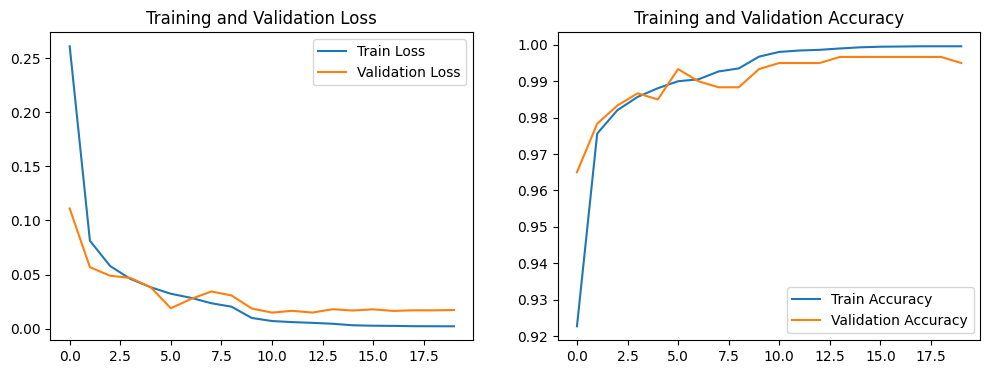

In [4]:
# 训练模型
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Epochs = 回合数
# Batch_size = 批次大小（自己设置）
# steps_per_epoch = 训练集大小//Batch_size
# validation_steps = 验证集大小//Batch_size
# model = model.fit(x_train, y_train, steps_per_epoch=steps_per_epoch, epochs=Epochs,
#                             validation_data=(x_val, y_val), validation_steps=validation_steps,
#                             callbacks=[tensorboard, checkpoint_callback])

# 定义训练回合，批次大小
epochs = 20
batch_size = 64

# 使用 Tensorboard 记录训练过程
tensorboard = TensorBoard(log_dir='logs/mnist1'.format(time()))

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# 训练模型
LeNet5_history = LeNet5.fit(x_train, y_train,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, y_val),
               callbacks=[tensorboard, checkpoint_callback, reduce_lr])

# 绘制训练和验证损失
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(LeNet5_history.history['loss'], label='Train Loss')
plt.plot(LeNet5_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制训练和验证准确率
plt.subplot(1, 2, 2)
plt.plot(LeNet5_history.history['accuracy'], label='Train Accuracy')
plt.plot(LeNet5_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

## 3. 评估模型性能

### 3.1 评估模型在测试集上的性能

In [5]:
# 验证模型在测试集上的准确率
LeNet5.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0309 - accuracy: 0.9918


[0.030905913561582565, 0.9918000102043152]

### 3.2 使用 precision recall  f1-score 这三个指标评估模型性能，并将混淆矩阵可视化。

313/313 [==============================] - 1s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



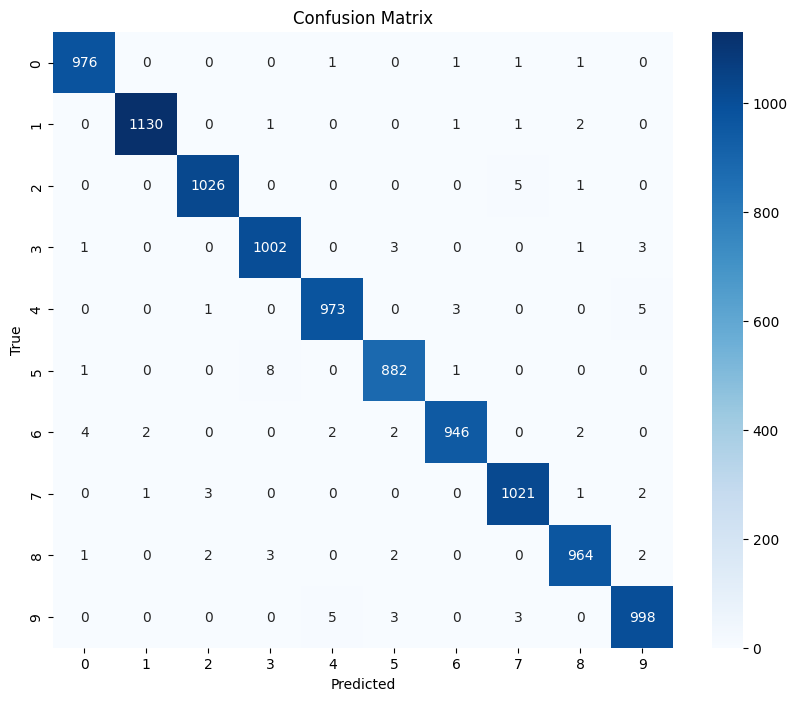

In [6]:
# 交叉验证
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

# 将预测值与真实值转为离散值
y_pred = LeNet5.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
y_test_classes = [np.argmax(element) for element in y_test]

# 数据集类别
classes = ["0","1","2","3","4","5","6","7","8","9"]

# 定义混淆矩阵
cm = confusion_matrix(y_test_classes, y_pred_classes)

# 打印 classification_report 结果
print("Classification Report: \n", classification_report(y_test_classes, y_pred_classes))

# 混淆矩阵可视化
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### 3.3 分类结果可视化

313/313 [==============================] - 1s 2ms/step
The real class of the 70th image in the test dataset is 7
The predicted class of the 70th image in the test dataset is 7


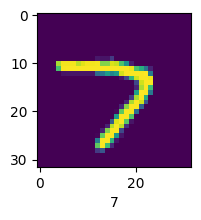

In [7]:
def verification(index, model):
    classes = ["0","1","2","3","4","5","6","7","8","9"]
    y_pred = model.predict(x_test)
    class_pred = [np.argmax(element) for element in y_pred]
    class_test = [np.argmax(element) for element in y_test]

    print(f'The real class of the {index}th image in the test dataset is {classes[class_test[index]]}')
    print(f'The predicted class of the {index}th image in the test dataset is {classes[class_pred[index]]}')
    plt.figure(figsize = (15,2))
    plt.imshow(x_test[index])
    plt.xlabel(classes[class_test[index]])

test_model = verification(70, LeNet5)

### 4. 更改 batch_size 大小，并对比模型性能的变化。简要讨论机器学习任务中 batch size 对训练的影响。（提示：可从算力、收敛效率、数据集特征等方面回答。）

#### 简要回答：
Batch size对机器学习任务中的影响是多方面的：

从算力来说，如果batch size太大，单次梯度求解虽然更准确了，但是所需要的算力和计算时间也变长了。

而从收敛速率上来说，如果每次用于计算梯度的batch size过小，那么每次梯度的计算就会更不稳定，从而容易在寻找全局最小值时较为跳脱，难以收敛到局部最优点。

在数据集特征上，如果单个数据点所占用内存较大，过大的batch size可能会导致内存不够，因为大的batch size需要更多的内存来存储中间计算结果和梯度，这可能限制模型的训练能力，特别是在GPU资源有限的情况下。